In [1]:
from google.colab import files

In [ ]:
files.upload()

In [ ]:
files.upload()

uploading new "model_evaluation_utils.py" from Week 7 "Sentiment Analysis Module".

In [ ]:
files.upload()

In [5]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
import pandas as pd
import numpy as np
import text_normalizer as tn
import model_evaluation_utils as meu
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')

%matplotlib inline  

In [44]:
df = pd.read_csv('/content/Spotify.csv')
df.head(15)

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN
5,2022-07-09 13:20:20,The player controls sometimes disappear for no...,3,7,NaN
6,2022-07-09 13:19:21,I love the selection and the lyrics are provid...,5,0,NaN
7,2022-07-09 13:17:22,Still extremely slow when changing storage to ...,3,16,NaN
8,2022-07-09 13:16:49,It's a great app and the best mp3 music app I ...,5,0,NaN
9,2022-07-09 13:11:32,"I'm deleting this app, for the following reaso...",1,318,NaN


The dataframe above shows that 'Review' column has features (including emojies) that we need to clean during the preprocessing step.

In [45]:
total_nulls = df[df.Review.str.strip() == ''].shape[0]
print("Empty documents:", total_nulls)

Empty documents: 0


In [46]:
df = df[~(df.Review.str.strip() == '')]
df.shape

(61594, 5)

# Preprocessing our data using text_normalizer.py

In [47]:
stopword_list = nltk.corpus.stopwords.words('english')

stopword_list.remove('no')
stopword_list.remove('not')
#stopword_list.remove('but') #if I use this, logistic regression accuracy goes down to .54%


norm_corpus = tn.normalize_corpus(corpus=df['Review'], html_stripping=True, contraction_expansion=True, 
                                  accented_char_removal=True, text_lower_case=True, text_lemmatization=True, 
                                  text_stemming=False, special_char_removal=True, remove_digits=True,
                                  stopword_removal=True, stopwords=stopword_list)
df['Clean Review'] = norm_corpus

In [56]:
df = df[['Review', 'Clean Review']]
df.head()

,Review,Clean Review
0,"Great music service, the audio is high quality...",great music service audio high quality app eas...
1,Please ignore previous negative rating. This a...,please ignore previous negative rating app sup...
2,"This pop-up ""Get the best Spotify experience o...",pop get good spotify experience android annoyi...
3,Really buggy and terrible to use as of recently,really buggy terrible use recently
4,Dear Spotify why do I get songs that I didn't ...,dear spotify get song not put playlist shuffle...


Now we have a new dataframe with the 2 columns we want -> Review and Clean Review.

In [51]:
df = df.replace(r'^(\s?)+$', np.nan, regex=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61594 entries, 0 to 61593
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Review        61594 non-null  object
 1   Clean Review  61594 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB


In [52]:
df = df.dropna().reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61594 entries, 0 to 61593
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Review        61594 non-null  object
 1   Clean Review  61594 non-null  object
dtypes: object(2)
memory usage: 962.5+ KB


In [57]:
df.to_csv('clean_Spotify.csv', index=False) # Save new csv file "clean_Spotify.csv"

In [58]:
df = pd.read_csv('/content/clean_Spotify.csv')

df = df[['Review', 'Clean Review']]
df.head()

,Review,Clean Review
0,"Great music service, the audio is high quality...",great music service audio high quality app eas...
1,Please ignore previous negative rating. This a...,please ignore previous negative rating app sup...
2,"This pop-up ""Get the best Spotify experience o...",pop get good spotify experience android annoyi...
3,Really buggy and terrible to use as of recently,really buggy terrible use recently
4,Dear Spotify why do I get songs that I didn't ...,dear spotify get song not put playlist shuffle...


# Functions for polarity, subjectivity, and sentiment using TextBlob. 

These functions contain the TextBlob '.sentment' in order to perform the predicted analysis.

We are going to import Textblob package to perform -> .sentiment on text to get the predicted polarity and subjectivity analysis. TextBlob is a pre-trained model works in a similar way to NLTK, using a BOW (bag of words) classifier
Typically, specific adjectives have a polarity score (negative/positive, -1.0 to +1.0) and a subjectivity score (objective/subjective, +0.0 to +1.0). The reliability score specifies if an adjective was hand-tagged (1.0) or inferred (0.7). Words are tagged per sense, e.g., ridiculous (pitiful) = negative, ridiculous (humorous) = positive.

In [59]:
from textblob import TextBlob

In [60]:
def polarity(txt):
    try:
        return TextBlob(txt).sentiment.polarity
    except:
        return None


def subjectivity(txt):
  try:
      return TextBlob(txt).sentiment.subjectivity
  except:
        return None


def analyze(x):
        if x < 0:
            return 'Negative'
        elif x == 0:
            return 'Neutral'
        else:
            return 'Positive'

In [63]:
df['polarity'] = df['Clean Review'].apply(polarity)
df['subjectivity'] = df['Clean Review'].apply(subjectivity)

In [64]:
df = df[['Review', 'Clean Review', 'polarity', 'subjectivity']]
df.head()

,Review,Clean Review,polarity,subjectivity
0,"Great music service, the audio is high quality...",great music service audio high quality app eas...,0.420333,0.624667
1,Please ignore previous negative rating. This a...,please ignore previous negative rating app sup...,0.166667,0.495833
2,"This pop-up ""Get the best Spotify experience o...",pop get good spotify experience android annoyi...,-0.050000,0.750000
3,Really buggy and terrible to use as of recently,really buggy terrible use recently,-0.266667,0.483333
4,Dear Spotify why do I get songs that I didn't ...,dear spotify get song not put playlist shuffle...,0.000000,0.000000


Lets calculate the 'sentiment' column using the polarity values.

In [65]:
df['sentiment'] = df['polarity'].apply(analyze)
df.head()

,Review,Clean Review,polarity,subjectivity,sentiment
0,"Great music service, the audio is high quality...",great music service audio high quality app eas...,0.420333,0.624667,Positive
1,Please ignore previous negative rating. This a...,please ignore previous negative rating app sup...,0.166667,0.495833,Positive
2,"This pop-up ""Get the best Spotify experience o...",pop get good spotify experience android annoyi...,-0.050000,0.750000,Negative
3,Really buggy and terrible to use as of recently,really buggy terrible use recently,-0.266667,0.483333,Negative
4,Dear Spotify why do I get songs that I didn't ...,dear spotify get song not put playlist shuffle...,0.000000,0.000000,Neutral


# Using Seaborn to visualize (bar plot) sentiment

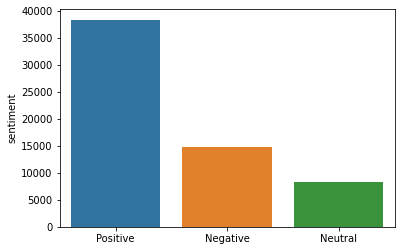

In [66]:
x = df['sentiment'].value_counts()
sns.barplot(x.index,x)

Lets create a new csv file with all these new columns.

In [67]:
df.to_csv('Spotify_Sentiment.csv', index=False) # Save new csv file "Spotify_Sentiment.csv"

# Making our own predictions using Logistic Regression

The logistic regression algorithm is the best option for this kinds of classification problem. This is a case of multi classification, since we are dealing with positive, neutral, and negative sentiment.

In [68]:
df = pd.read_csv('/content/Spotify_Sentiment.csv')
df.head()

,Review,Clean Review,polarity,subjectivity,sentiment
0,"Great music service, the audio is high quality...",great music service audio high quality app eas...,0.420333,0.624667,Positive
1,Please ignore previous negative rating. This a...,please ignore previous negative rating app sup...,0.166667,0.495833,Positive
2,"This pop-up ""Get the best Spotify experience o...",pop get good spotify experience android annoyi...,-0.050000,0.750000,Negative
3,Really buggy and terrible to use as of recently,really buggy terrible use recently,-0.266667,0.483333,Negative
4,Dear Spotify why do I get songs that I didn't ...,dear spotify get song not put playlist shuffle...,0.000000,0.000000,Neutral


In [69]:
df = df[['Review', 'Clean Review', 'sentiment']]
df.head()

,Review,Clean Review,sentiment
0,"Great music service, the audio is high quality...",great music service audio high quality app eas...,Positive
1,Please ignore previous negative rating. This a...,please ignore previous negative rating app sup...,Positive
2,"This pop-up ""Get the best Spotify experience o...",pop get good spotify experience android annoyi...,Negative
3,Really buggy and terrible to use as of recently,really buggy terrible use recently,Negative
4,Dear Spotify why do I get songs that I didn't ...,dear spotify get song not put playlist shuffle...,Neutral


# Train and Test Datasets

In [70]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(np.array(df['Clean Review']), np.array(df['sentiment']), test_size = 0.33, random_state = 42)

x_train.shape, x_test.shape

((41267,), (20327,))

# Feature Engineering using TFIDF (better performance)

Building TFIDF Features on Train Datasets.

In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score

tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0, ngram_range=(1,2),
                     sublinear_tf=True)
tv_train_features = tv.fit_transform(x_train)

Transform Test Datasets into features.

In [72]:
tv_test_features = tv.transform(x_test)

Lets print out the shape:

In [75]:
print('TFIDF model:> Train features shape:', tv_train_features.shape, ' Test features shape:', tv_test_features.shape)

TFIDF model:> Train features shape: (41267, 213836)  Test features shape: (20327, 213836)


#Logistic Regression

In [76]:
from sklearn.linear_model import LogisticRegression

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

lr_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                        ('lr', LogisticRegression(penalty='l2', max_iter=500, C=1, random_state=42))
                       ])

param_grid = {'tfidf__ngram_range': [(1, 1), (1, 2)],
              'lr__C': [1, 5, 10]
}

gs_lr = GridSearchCV(lr_pipeline, param_grid, cv=5, verbose=2)
gs_lr = gs_lr.fit(x_train, y_train)

In [ ]:
gs_lr.best_estimator_.get_params()

# Test Accuracy

In [79]:
best_lr_test_score = gs_lr.score(x_test, y_test)
print('Test Accuracy :', best_lr_test_score)

Test Accuracy : 0.9255177842278742


In [80]:
lr_predictions = gs_lr.predict(x_test)
unique_classes = list(set(y_test))
meu.get_metrics(true_labels=y_test, predicted_labels=lr_predictions)

Accuracy: 0.9255
Precision: 0.925
Recall: 0.9255
F1 Score: 0.925


In [81]:
meu.display_classification_report(true_labels=y_test, 
                                  predicted_labels=lr_predictions, classes=unique_classes)

              precision    recall  f1-score   support

    Negative       0.89      0.84      0.87      4945
    Positive       0.94      0.96      0.95     12698
     Neutral       0.90      0.93      0.91      2684

    accuracy                           0.93     20327
   macro avg       0.91      0.91      0.91     20327
weighted avg       0.93      0.93      0.93     20327



# Prediction using Logistic Regression on TF-IDF Features

In [82]:
train_idx, test_idx = train_test_split(np.array(range(len(df['Review']))), test_size=0.33, random_state=42)
test_idx

array([37326, 50640, 27630, ..., 46086, 11883, 25133])

In [83]:
predict_probas = gs_lr.predict_proba(x_test).max(axis=1)
test_df = df.iloc[test_idx]
test_df['Predicted Sentiment'] = lr_predictions
test_df['Predicted Confidence'] = predict_probas
test_df.head()

,Review,Clean Review,sentiment,Predicted Sentiment,Predicted Confidence
37326,"What is going on, Spotify? Nothing will play n...",go spotify nothing play no matter fix,Neutral,Neutral,0.709332
50640,"Music that's matched to me, spot on!!!!! Thank...",music match spot thank spotify write word revi...,Negative,Positive,0.513084
27630,Lots of bugs in the latest version,lot bug late version,Negative,Negative,0.993553
42850,"Damn, Spotify used to be an amazing streaming ...",damn spotify use amazing streaming platform co...,Positive,Positive,0.991416
10950,Never have been annoyed in my entire life than...,never annoy entire life use application,Neutral,Neutral,0.688534
